v2 - Rajeev cleaning up

### Module 1
- Presentation : Tell the story of how module 1 and module 2 are designed
- WS Module Setup and Introduction (@chirag/@rajeev)
- Part 1: Data and embeddings 
   - Introduction to vector embedding
   - simple t-SNE vector representation
- Part 2: Introduction to pgvector
   1. Show how to create a table with vector data type 
   2. Ingest the data with vector(512) ( Runbook will provided 2-3 runbooks+doc, which will be used in module2)
   3. User query ex: "how to deal with DB with high CPU?"
   4. Visual representation of the results (tSNE)
   5. Ingest data with vector(1024) and Visual representation of the results (tSNE)
   5. Show the indexing? @davechir
   Optional--> Injest data with vector(1024)

# Module 1: Create and visualize embeddings for your dataset

In this notebook, we will generate embedding and visualize embedding through TSN-E. For a specific dataset, persist embedding in pgvector/Aurora and create HNSW and IVVFlat indexes and then perform similarity search.


1. [Generate Embeddings using Amazon Titan Text Embeddings Model](#test)
2. [Visualize Embeddings using t-SNE](#test)
3. [Download Dataset](#test)
4. [Insert embeddings into PostgreSQL with pgvector extention] (#test)
5. [Perform similarity seatch](#test)




## Install package dependencies

In [26]:
!pip install langchain langchain-postgres langchain-aws langchain-community PyPDF2 --quiet
%pip install setuptools==65.5.0 --quiet
%pip install -U pgvector pandarallel boto3 psycopg numexpr --quiet
%pip install unstructured nltk --quiet
%pip install --upgrade psycopg --quiet
%pip install --upgrade sagemaker --quiet
%pip install pandas --quiet
%pip install numexpr --quiet
%pip install scikit-learn --quiet
%pip install matplotlib --quiet
%pip install seaborn --quiet
%pip install matplotlib --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.34.25 requires botocore==1.35.25, but you have botocore 1.34.162 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.34.25 requires botocore==1.35.25, but you have botocore 1.35.34 which is incompatible.
langchain-aws 0.1.18 requires boto3<1.35.0,>=1.34.131, but you have boto3 1.35.34 which is incompatible.
langchain-postgres 0.0.9 requires pgvector<0.3.0,>=0.2.5, but you have pgvector 0.3.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to u

## Imports and setup

In [27]:
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt 
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE

In [28]:
import boto3
import json
import os
import io
import collections
from langchain_core.documents import Document

In [29]:
s3_client = boto3.client("s3")
bedrock_client = boto3.client("bedrock-runtime")
sm_client = boto3.client('secretsmanager')

embeddings_model_id = 'amazon.titan-embed-text-v2:0'
s3_bucket_name = 'dat307-bedrockkb-3tdatv7ewfis'
prefix='runbook'
local_dir = 'docs/'

## Part-1 Objective: Learn the concepts of embeddings & vector spaces
Objective of this part is to understand the concepts essential for building semantic search based applications. 


### Utility function : generate_embeddings

The `generate_embeddings` function is responsible for generating text embeddings using the Amazon Titan Text Embeddings v2 model.

Here's a breakdown of what the function is doing:

1. It takes two arguments:
   - `model_id`: The ID of the Amazon Titan Text Embeddings v2 model to use for generating the embeddings.
   - `body`: A JSON-formatted string containing the input text and configuration options for the embedding generation.

2. It creates a Boto3 client for the "bedrock-runtime" service, which is used to interact with the Amazon Bedrock service (the underlying infrastructure that provides the Titan Text Embeddings model).

3. It sets the `accept` and `content_type` headers to indicate that the request and response should be in JSON format.

4. It invokes the specified model (`model_id`) using the Boto3 client's `invoke_model` method, passing the `body` as the request payload.

5. It reads the response body, which contains the generated embedding vector and the number of input tokens, and converts it from a JSON string to a Python dictionary.

6. Finally, it returns the embedding vector and input token count as a dictionary.

This function is used throughout the notebook to generate embeddings for the text data, both for the initial set of example texts and for the text content extracted from the downloaded files.

The generated embeddings can then be used for various tasks, such as similarity search, visualization, or training machine learning models that rely on text embeddings.

In [30]:
import json
import logging
import boto3
from botocore.exceptions import ClientError

def generate_embeddings(model_id, body):
    """
    Generate a vector of embeddings for a text input using Amazon Titan Text Embeddings v2 on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        response (JSON): The embedding created by the model and the number of input tokens.
    """

    bedrock = boto3.client(service_name='bedrock-runtime')

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )

    response_body = json.loads(response.get('body').read())

    return response_body

### Utility function : get_embeddings_df

The `get_embeddings_df` function is responsible for generating the embeddings for a given set of text inputs and creating a pandas DataFrame that contains the text and their corresponding embeddings.

Here's a breakdown of what the function is doing:

1. It takes a list of text inputs (`texts`) as the argument.
2. It creates a new pandas DataFrame with the text inputs as the "text" column.
3. It then applies the `generate_embeddings` function to each text input in the "text" column. This function uses the Amazon Titan Text Embeddings v2 model to generate a 1024-dimensional embedding vector for each text input.
4. The generated embedding vectors are stored in the "embedding" column of the DataFrame.
5. Finally, the function returns the resulting DataFrame, which contains the original text inputs and their corresponding embeddings.

This function is useful for quickly generating embeddings for a set of text data, which can then be used for further processing, such as similarity search, visualization, or training machine learning models.

In [31]:
import pandas as pd

def get_embeddings_df(texts):
    df = pd.DataFrame(texts, columns=["text"])
    df["embedding"] = df["text"].apply(lambda text: generate_embeddings(embeddings_model_id, json.dumps
    ({"inputText": text, "dimensions": 1024, "normalize": True})).get('embedding'))
    return df

### Sample data
This is to demonstrate how the data gets organized in a vector space.

PS: You may change the data and see its distribution in the vector space.

In [32]:
# Sample data for learning the concepts
texts = [
    "Red",
    "White",
    "Blue",
    "Fish",
    "Horse",
    "Cat",
    "Orange",
    "USA",
    "Canada",
    "Japan"
]

# Call utility function to generate the embeddings
df = get_embeddings_df(texts)

# Show the embeddings
display(df)


,text,embedding
0,Red,"[-0.05807836353778839, -0.00508491974323988, -..."
1,White,"[-0.0540415421128273, 0.026241326704621315, -0..."
2,Blue,"[0.0031653610058128834, -0.025714479386806488,..."
3,Fish,"[-0.016262708231806755, 0.07564049959182739, 0..."
4,Horse,"[-0.02816365659236908, 0.057637251913547516, 0..."
5,Cat,"[-0.032960548996925354, 0.05227337032556534, 0..."
6,Orange,"[-0.06927792727947235, 0.03239615261554718, -0..."
7,USA,"[-0.01883060857653618, 0.04099179804325104, 0...."
8,Canada,"[-0.03434763103723526, 0.04349052160978317, -0..."
9,Japan,"[0.004475247580558062, 0.029382314532995224, -..."


### Utility function : show_tsne_plot

The `show_tsne_plot` function is responsible for visualizing the text embeddings using t-SNE (t-Distributed Stochastic Neighbor Embedding).

TSNE reduces the dimensionality of the embeddings from 1024 (in this example) to 2. This helps with the understanding of the distribution of embeddings in the vector space created with the chunks.

Here's a breakdown of what the function is doing:

1. It takes a DataFrame `df` as input, which should contain a "text" column with the text inputs and an "embedding" column with the corresponding 1024-dimensional embedding vectors.

2. It extracts the embedding vectors from the DataFrame and stores them in a NumPy array.

3. It creates a t-SNE instance with the following configurations:
   - `n_components=2`: Reduces the 1024-dimensional embeddings to a 2-dimensional space for visualization.
   - `learning_rate="auto"`: Automatically selects the learning rate for the t-SNE algorithm.
   - `init="random"`: Initializes the 2D embeddings randomly.
   - `random_state=4`: Sets a random seed for reproducibility.
   - `perplexity=3`: Controls the balancing of local and global structures in the t-SNE visualization.

4. It applies the t-SNE algorithm to the embedding vectors, transforming them into a 2-dimensional representation.

5. It creates a new figure and scatter plot to visualize the 2D embeddings. The embeddings are plotted as blue dots, and the text labels are added as annotations next to each point.

6. It calculates the cosine similarity matrix for the embedding vectors and uses this to draw connecting lines between the 2D embedding points. The width and transparency of the lines are proportional to the cosine similarity between the corresponding embeddings.

7. It adds a title to the plot and displays the visualization.

This function allows you to visually inspect the relationships between the text embeddings, as similar texts will be grouped together in the 2D t-SNE plot, and the connections between them will reflect their cosine similarity.

The visualization can be useful for understanding the semantic structure of the text data and evaluating the quality of the generated embeddings.

In [33]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

def show_tsne_plot(df):
    embeddings = np.array(df["embedding"].tolist())

    tsne = TSNE(n_components=2, learning_rate="auto", init="random", random_state=4, perplexity=3)
    embeddings_2d = tsne.fit_transform(embeddings)

    # plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c="blue", alpha=0.6, label="Embeddings")

    for i, txt in enumerate(df["text"]):
        plt.annotate(
            txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0, 5), ha="center"
        )

    similarity_matrix = cosine_similarity(embeddings)

    # lines
    for i in range(len(embeddings_2d)):
        for j in range(i+1, len(embeddings_2d)):  # avoid repeating the same pair
            sim = similarity_matrix[i, j]
            # higher similarity = bolder lines
            alpha = sim 
            if sim > 0:  # plot lines for positive similarity values
                plt.plot(
                    [embeddings_2d[i, 0], embeddings_2d[j, 0]],
                    [embeddings_2d[i, 1], embeddings_2d[j, 1]],
                    color='gray', linestyle='-', alpha=alpha, linewidth=2*sim
                )

    plt.title("2D Visualization of Text Embeddings using t-SNE with Cosine Similarity")
    plt.legend()
    plt.show()

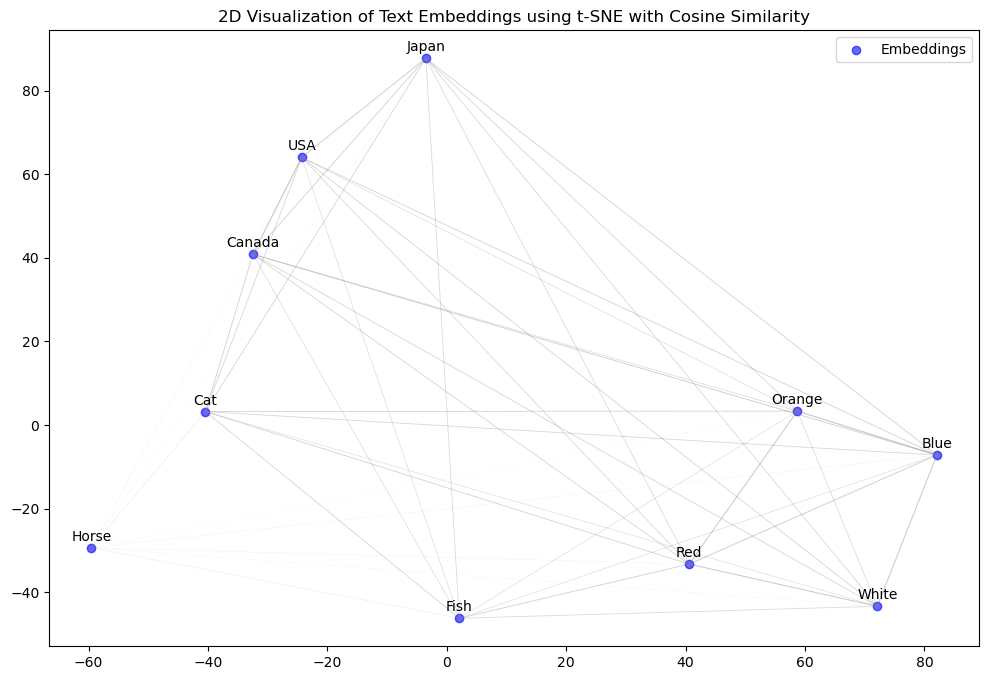

In [11]:
show_tsne_plot(df)

## Part-2 Objective: Setup vector database for the incident management application

So far you have learned how to use embeddings and the idea of semantic similarity. We will now apply the concepts to build our vector index. The data in the vector database will consist of 2 types of elements:

1. PostgreSQL user and administration guide
Since these guides are large in size, they will be chunked. The size of the chunk can be tuned based on the search results. Semantic search will retrieve a set of appropriate chunks based on the query. Since the LLM will not need to go through the entire document for each query, use of semantic search will improve the performance of the LLM and at the same time reduce the cost of LLM usage, as the number of tokens in input will be reduced significantly.

2. Runbooks for addressing specific alerts
The size of the runbook is small (few KBs) and they will be needed in entirety by the agent, we have decided to NOT chunk the runbooks. In other words a complete runbook will be in a single chunk. In order to accompalish this, it is suggested that you keep the chunk size > (largest runbook x 1.75)

### Utility function : 
To make things easy we have added all of the PostgreSQL documentation (.pdf) and the Runbooks (.md)in a common S3 bucket. This utlity function downloads the (.pdf) files from S3 bucket to local file system.

The `download_all_files` function is responsible for downloading a set of PDF files from an S3 bucket and saving them to a local directory.

Here's a breakdown of what the function is doing:

1. It takes three arguments:
   - `bucket_name`: The name of the S3 bucket to download files from.
   - `prefix`: The prefix or directory path within the S3 bucket where the files are located.
   - `local_dir`: The local directory path where the files will be downloaded and saved.

2. It first checks if the local directory exists, and if not, it creates the directory.

3. It creates a paginator object using the Boto3 S3 client, which allows it to list the objects in the S3 bucket in a paginated manner.

4. It then iterates through the pages of objects returned by the paginator.

5. For each object, it checks if the file key (the object's path within the S3 bucket) ends with ".md" (indicating a Markdown file).

6. If the file key ends with ".md", it constructs the local file path by joining the local directory and the file key.

7. If the file key contains a directory path (indicated by the presence of a "/" in the key), it creates the necessary subdirectories in the local directory.

8. It then downloads the file from the S3 bucket using the Boto3 S3 client's `download_file` method, saving it to the local file path.

9. If the file key does not end with ".md", it skips the file and prints a message indicating that it is not a Markdown file.

10. If the paginator returns no objects, it prints a message indicating that no files were found under the specified prefix.

This function is used in the notebook to download a set of Markdown and PDF files from an S3 bucket, which are then processed and used to generate text embeddings and store them in the PostgreSQL database.

In [34]:
import boto3
import os

def download_all_files(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    paginator = s3_client.get_paginator('list_objects_v2')
    response_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    for page in response_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                file_key = obj['Key']

                if file_key.endswith('.md'):
                    file_name = os.path.join(local_dir, file_key)
                    if '/' in file_key:
                        os.makedirs(os.path.dirname(file_name), exist_ok=True)
                    print(f'Downloading {file_key} to {file_name}')
                    s3_client.download_file(bucket_name, file_key, file_name)
                else:
                    print(f'Skipping {file_key} (not an .md file)')
        else:
            print(f'No files found under the prefix {prefix}')

In [35]:
download_all_files(s3_bucket_name, prefix, local_dir)

Skipping runbook/ (not an .md file)


### Create the table for embeddings

1. Connect to PostgreSQL database, that has already been created for you
2. Create a table {table_name} if it does not exist

In [37]:
import psycopg
from psycopg2 import sql 

response = sm_client.get_secret_value(SecretId='apgpg-pgvector-secret')
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']

dbconn = psycopg.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10, autocommit=True)

def create_table(table_name, vector_dim):
    vector_dim = int(vector_dim)
    cur = dbconn.cursor()
    
    cur.execute(f"""
        SELECT EXISTS (
            SELECT 1
            FROM information_schema.tables
            WHERE table_schema = 'public' AND table_name = '{table_name}'
        );
        """)
    exists = cur.fetchone()[0]

    if exists:
        print(f"Table '{table_name}' already exists.")
    else: 
        try:
            cur.execute(f"""
                    CREATE TABLE {table_name} (
                        _id SERIAL PRIMARY KEY,
                        id TEXT,
                        chunk TEXT,
                        embedding VECTOR({vector_dim}),
                        metadata JSONB
                    );
                """)
        except Exception as e:
            dbconn.rollback()
            print(f"An error occurred while creating the table: {e}")
    
    dbconn.commit()
    cur.close()

### Utility functions to populate the database table with embeddings/metadata

In [38]:
from PyPDF2 import PdfReader
import json
import psycopg
from psycopg import sql
from psycopg.types.json import Json
from langchain.text_splitter import RecursiveCharacterTextSplitter
import boto3
from botocore.exceptions import ClientError
import os
import nltk
import traceback

# Download NLTK 'punkt' tokenizer data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Read the content of the file
def get_text_from_file(file_path):
    """
    Split the given text into smaller chunks using a RecursiveCharacterTextSplitter.

    Args:
        text (str): The input text to be chunked.
        chunk_size (int): The maximum size (in characters) of each chunk.

    Returns:
        list: A list of text chunks, or None if an exception occurs.

    Raises:
        Exception: If an error occurs during the text chunking process.
    """
    try:
        if file_path.endswith('.pdf'):
            text = ""
            pdf_reader = PdfReader(file_path)
            for page in pdf_reader.pages:
                text += page.extract_text()
            return text
        elif file_path.endswith('.md'):
            with open(filepath, 'r') as f:
                text = f.read()
            return text
        else:
            raise ValueError(f"Unsupported file type for file {file_path}")
    except Exception as e:
        print(f"Error in get_text_from_file for file {file_path}: {e}")
        traceback.print_exc()
        return None

# Break the content of file into chunks
def get_text_chunks(text, chunk_size):
    try:
        text_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", ".", " "],
            chunk_size=chunk_size,
            chunk_overlap=200,
            length_function=len
        )
        chunks = text_splitter.split_text(text)
        return chunks
    except Exception as e:
        print(f"Error in get_text_chunks: {e}")
        traceback.print_exc()
        return None

# Add the chunks and metadata to the table
def store_embeddings(dbconn, data: dict):
    """
    Store text embeddings and associated data in a PostgreSQL database.

    Args:
        dbconn (psycopg.Connection): The PostgreSQL database connection.
        data (dict): A dictionary containing the following keys:
            - 'table': The name of the table to store the data in.
            - 'chunks': A list of text chunks.
            - 'embeddings': A list of corresponding embedding vectors.
            - 'metadata': A dictionary of metadata associated with the text chunks.

    Raises:
        Exception: If an error occurs during the execution of the function.
    """
    try:
        cur = dbconn.cursor()
        _table_name = data.get('table')
        _chunks = data.get('chunks')
        _embeddings = data.get('embeddings')
        _metadata = data.get('metadata')

        insert_query = sql.SQL(
            "INSERT INTO {} (chunk, embedding, metadata) VALUES (%s, %s, %s);"
        ).format(
            sql.Identifier(_table_name)
        )

        for chunk, embedding in zip(_chunks, _embeddings):
            cur.execute(
                insert_query.as_string(dbconn),
                (
                    chunk,
                    embedding,
                    Json(_metadata)
                )
            )

        dbconn.commit()
        cur.close()
    except Exception as e:
        print(f"Error in store_embeddings: {e}")
        traceback.print_exc()

# Utility function to process the PDF files
def process_file(file_path, dbconn, table_name, metadata, chunk_size=300, dim=1024):
    """
    Process a file, extract its text content, generate embeddings, and store the data in a PostgreSQL database.

    Args:
        file_path (str): The file path of the input file.
        dbconn (psycopg.Connection): The PostgreSQL database connection.
        table_name (str): The name of the table to store the data in.
        metadata (dict): A dictionary of metadata to associate with the text chunks.
        chunk_size (int, optional): The maximum size (in characters) of each text chunk. Default is 300.
        dim (int, optional): The dimensionality of the text embeddings. Default is 1024.

    Raises:
        ValueError: If the file type is not supported or if the `chunk_size` is not provided for PDF files.
        Exception: If an error occurs during the processing of the file.
    """
    try:
        content = get_text_from_file(file_path)
        if content is None:
            print(f"Skipping file {file_path} due to previous error.")
            return

        # Initialize variables
        chunks = []
        embeddings = []

        if file_path.endswith('.md'):
            # Do not chunk the Markdown file content
            chunks = [content]
            body = json.dumps({"inputText": content, "dimensions": dim, "normalize": True})
            embedding = generate_embeddings(embeddings_model_id, body).get('embedding')
            embeddings = [embedding]

        elif file_path.endswith('.pdf'):
            if chunk_size is None:
                raise ValueError("chunk_size must be provided for PDF files.")
            chunks = get_text_chunks(content, chunk_size=chunk_size)
            if not chunks:
                print(f"Skipping file {file_path} due to error in get_text_chunks.")
                return

            # Generate embeddings for all chunks
            for chunk in chunks:
                body = json.dumps({"inputText": chunk, "dimensions": 1024, "normalize": True})
                response = generate_embeddings(embeddings_model_id, body)
                if not response:
                    print(f"Skipping chunk due to error in generate_embeddings.")
                    continue
                embedding = response.get('embedding')
                embeddings.append(embedding)
        else:
            raise ValueError(f"Unsupported file type for file {file_path}")

        # Prepare data for storage
        data = {
            'table': table_name,
            'id': os.path.basename(file_path),
            'chunks': [chunks],
            'embeddings': embeddings,
            'metadata': metadata
        }

        store_embeddings(dbconn, data)
    except Exception as e:
        print(f"Error in process_file for file {file_path}: {e}")
        traceback.print_exc()


### Create the table with the specified vector dimension

In [39]:
# the below 2 cells needs to be repeated for 512 dimensions
file_path = "docs/runbook"

table_name = 'module1_1024_gaiamogh_v2'
create_table(table_name, 1024)
dim=1024

Table 'module1_1024_gaiamogh_v2' already exists.


In [ ]:
### Process the files in the 

In [40]:
# process all files in the directory
for filename in os.listdir(file_path):
    filepath = os.path.join(file_path, filename)
    if os.path.isfile(filepath):
        try:
            if filename.endswith(".pdf"):
                metadata = {'source': 'pdf'}
                process_file(
                    filepath,
                    dbconn,
                    table_name,
                    metadata,
                    dim,
                    chunk_size=300  # Adjust chunk size as needed
                )
            elif filename.endswith(".md"):
                metadata = {'source': 'runbook'} 
                process_file(filepath, dbconn, table_name, metadata, dim)
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
            traceback.print_exc()

### Search through pg vector

In [41]:
import numpy
user_query = "remediate RDS IOPS"
body = json.dumps({"inputText": user_query, "dimensions": 1024, "normalize": False})
user_embedding = numpy.array(generate_embeddings(embeddings_model_id, body)['embedding'])

In [51]:
import numpy
from IPython.display import display, Markdown, Latex, HTML
from pgvector.psycopg import register_vector
import psycopg

def similarity_search(embedding):

    dbconn = psycopg.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
    register_vector(dbconn)
    
    r= dbconn.execute("""SELECT chunk, embedding
                         FROM module1_1024_gaiamogh_v2
                         ORDER BY embedding <=> %s limit 8;""",(embedding,)).fetchall()
    for (x,y) in r:
        print(x)
        print("------------------")
        print(y)
    return r

In [52]:
r = similarity_search(user_embedding)

{"# Title
Runbook to remediate RDS IOPS reaching limit

## Issue
PostgreSQL database instance is running out of IOPS provisioned.

## Description
This run book provides the step by step instructions to increase the RDS IOPS if it reaches the provisioned limit.
Follow the instrctions in this run book to remediate the issues related to the iops limit.

## Steps

1. Check if the RDS instance is in available state. If the status is available, continue otherwise abort the process.

2. Get the maximum IOPS metrics usage for the last 1 hour for the RDS instance. 

3. Get the provisioned iops of the RDS instance. 

4. Check if the maximum IOPS utilization from the IOPS metrics is 80% of the provisioned IOPS then increase it by 20%, if it is less than 80%  increase it by 10%.
"}
------------------
[-0.01937964  0.02705475  0.03952679 ... -0.01204032 -0.04816129
 -0.01117687]
{"# Title
Runbook to remediate RDS IOPS reaching limit

## Issue
PostgreSQL database instance is running out of IOPS prov

In [53]:
formatted_text = []
for (x,y) in r:
    formatted_text.append((x[0:50],y))
print(formatted_text[0])

('{"# Title\nRunbook to remediate RDS IOPS reaching l', array([-0.01937964,  0.02705475,  0.03952679, ..., -0.01204032,
       -0.04816129, -0.01117687], dtype=float32))


In [54]:
df = pd.DataFrame(formatted_text, columns=['text','embedding'])

In [55]:
df

,text,embedding
0,"{""# Title\nRunbook to remediate RDS IOPS reach...","[-0.019379642, 0.027054748, 0.039526794, -0.01..."
1,"{""# Title\nRunbook to remediate RDS IOPS reach...","[-0.019379642, 0.027054748, 0.039526794, -0.01..."
2,"{""# Title\nRunbook to remediate RDS IOPS reach...","[-0.019379642, 0.027054748, 0.039526794, -0.01..."
3,"{""# Title\nRunbook to remediate RDS IOPS reach...","[-0.019379642, 0.027054748, 0.039526794, -0.01..."
4,"{""# Title\nRunbook to remediate RDS IOPS reach...","[-0.019379642, 0.027054748, 0.039526794, -0.01..."
5,"{""# Title\nRunbook to remediate RDS CPU Utiliz...","[-0.0193665, 0.016507635, 0.022040922, -0.0110..."
6,"{""# Title\nRunbook to remediate RDS CPU Utiliz...","[-0.0193665, 0.016507635, 0.022040922, -0.0110..."
7,"{""# Title\nRunbook to remediate RDS CPU Utiliz...","[-0.0193665, 0.016507635, 0.022040922, -0.0110..."


In [56]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

def show_tsne_plot(df, query_text):
    
    query_embedding = generate_embeddings(
        embeddings_model_id,
        json.dumps({"inputText": query_text, "dimensions": 1024, "normalize": True})
    ).get('embedding')

    df_with_query = pd.concat([
        df,
        pd.DataFrame({"text": [query_text], "embedding": [query_embedding]})
    ], ignore_index=True)

    embeddings = np.array(df_with_query["embedding"].tolist())

    tsne = TSNE(n_components=2, learning_rate="auto", init="random", random_state=4, perplexity=3)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # plot
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1],
                c="blue", alpha=0.6, label="Answers")

    plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1],
                c="green", marker="*", s=200, label="User Query")  # change color

    for i, txt in enumerate(df_with_query["text"]):
        plt.annotate(
            f"{i+1}-{txt}", (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0, 5), ha="center"
        )

    similarity_matrix = cosine_similarity(embeddings)
    
    user_query_idx = len(embeddings_2d) - 1 

    # lines
    for i in range(len(embeddings_2d)):
        for j in range(i+1, len(embeddings_2d)):  # avoid repeating the same pair
            sim = similarity_matrix[i, j]
            # Ensure alpha is within [0, 1]
            alpha = np.clip(sim, 0, 1)
            if sim > 0:
                if i == user_query_idx:
                    line_color = 'red'
                else:
                    line_color = 'grey'
                # plot lines for positive similarity values
                plt.plot(
                    [embeddings_2d[i, 0], embeddings_2d[j, 0]],
                    [embeddings_2d[i, 1], embeddings_2d[j, 1]],
                    color=line_color, linestyle='-', alpha=alpha, linewidth=2*sim
                )

    plt.title("2D Visualization of Text Embeddings using t-SNE with Cosine Similarity")
    plt.legend()
    plt.show()

In [50]:
show_tsne_plot(df, user_query)

ValueError: perplexity must be less than n_samples